# Overall Story
#### Pratool Gadtaula and Jay Woo

Every day, tons of reviews are posted on Rotten Tomatoes, ranging from glowingly positive to vehemently negative. Often, it is useful for a computer to calculate sentiment automatically, so that a human doesn't have to sift through all the data manually. For the most part, this problem can be solved by feeding the data into a natural language processing model that calculates the sentiment of new reviews. However, there is a lot of nuance in the English language, and a lot of different factors need to be taken into consideration.

The Kaggle competition we downloaded the data from can be found here: https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews, and our approach to this problem is detailed below!

In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.tag.perceptron import PerceptronTagger
import pattern.en
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/home/wooj/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
train = pd.read_csv('train.tsv', sep='\t')
test = pd.read_csv('test.tsv', sep='\t')

test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


## Extracting Parts of Speech

One major property of language is part of speech. After watching Coursera lectures on NLP (https://class.coursera.org/nlp/lecture) we decided to tag the part of speech of each word in the data using the averaged perceptron tagger provided by NLTK (https://spacy.io/blog/part-of-speech-POS-tagger-in-python). However, it is important to note that taggers are not very good at handling sentence ambiguity (“Republicans grill IRS chief over lost emails”), thus yielding an accuracy of around 57% at best (http://nlp.stanford.edu/pubs/CICLing2011-manning-tagging.pdf). The NLTK-provided tagger has many different parts of speech, so in order to prevent the model from overfitting, we only used 4 categories: adjectives, adverbs, verbs, and nouns (inspired by http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=5212278). For our approach, we assumed a bag of words model, which essentially says that it doesn't matter what order everything is in.

In [3]:
# Load the tagger for faster tagging
tagger = PerceptronTagger()

def tag_all_phrases(df):
    data = df
    data["POS"] = data["Phrase"].apply(
        lambda x: [tag[1] for tag in \
                   nltk.tag._pos_tag(nltk.word_tokenize(x), None, tagger)] )
    return data

data_pos = tag_all_phrases(train)

In [4]:
def get_words(df):
    data = df[~(df['Phrase'].str.contains(' '))]
    data = data[data.Phrase.str.contains('^[a-zA-Z]+$')]
    data.Phrase = data.Phrase.str.lower()
    return data

def extract_single_POS_from_words(df):
    data = df
    data["POS"] = data["POS"].apply(lambda x: x[0])
    return data

words_pos = get_words(data_pos)
words_pos = extract_single_POS_from_words(words_pos)
words_pos.head(10)

,PhraseId,SentenceId,Phrase,Sentiment,POS
3,4,1,a,2,DT
4,5,1,series,2,NN
6,7,1,of,2,IN
8,9,1,escapades,2,NNS
11,12,1,demonstrating,2,VBG
13,14,1,the,2,DT
14,15,1,adage,2,NN
16,17,1,that,2,IN
18,19,1,what,2,WP
20,21,1,is,2,VBZ


In [5]:
# Prints all of the unique parts of speech that have been tagged
print sorted(words_pos['POS'].unique())

['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'MD', 'NN', 'NNP', 'NNS', 'PRP', 'PRP$', 'RB', 'RBR', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']


The tags in the "POS" column represent different parts of speech, and the definitions for each abbreviation can be found here: <a href="https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html">part of speech tags used by the Penn Treebank</a>. Now that we have these parts of speech, we can separate each word into 5 categories - noun, adjective, adverb, verb, or miscellaneous.

In [6]:
def get_general_POS(data):
    pos_map = {
        "NNS":"noun",
        "NN":"noun",
        "NNP":"noun",
        "NNPS":"noun",
        "RB":"adverb",
        "RBR":"adverb",
        "RBS":"adverb",
        "VB":"verb",
        "VBD":"verb",
        "VBG":"verb",
        "VBN":"verb",
        "VBP":"verb",
        "VBZ":"verb",
        "JJ":"adjective",
        "JJR":"adjective",
        "JJS":"adjective"
    }
    if data not in pos_map: return "misc"
    else:                   return pos_map[data]

words_pos['POS2'] = words_pos['POS'].apply(get_general_POS)
words_pos.head()

,PhraseId,SentenceId,Phrase,Sentiment,POS,POS2
3,4,1,a,2,DT,misc
4,5,1,series,2,NN,noun
6,7,1,of,2,IN,misc
8,9,1,escapades,2,NNS,noun
11,12,1,demonstrating,2,VBG,verb


Finally, we put all of this data into a dictionary, so we can simply look up the part of speech of any word we encounter in the test set. It is important to note that the part of speech of some of these words will change based on the context that it is used in. Ideally, we would not have any of these ambiguities in the data, but for now, we can assume this is negligible.

In [7]:
# Stores all of the parts of speech in a dictionary
phrase_iter = words_pos.Phrase.values
pos_iter = words_pos.POS2.values
part_of_speech = dict(zip(phrase_iter, pos_iter))

## Generating a Corpus

At a first glance, we noticed that the phrases in the data had a wide range of lengths. In order to get a feeling of how the words were classified, we only looked at the sentiments of phrases containing single words first. From the data, we built a dictionary that stores all of the one-word phrases and their associated sentiments.

We also tried building a corpus of all two-word phrases, but that ended up overfitting the training data pretty badly. The data has $N$ unique words, so theoretically, there are around $N^2$ unique word pairs. The training data only has a small portion of all the $N^2$ combinations, causing our model to overfit to a small set of quirks.

In [8]:
# Extracts one-word phrases using a regular expression
single_words = train[~train.Phrase.str.contains(' ')]
single_words = single_words[single_words.Phrase.str.contains('^[a-zA-Z]+$')]
single_words.Phrase = single_words.Phrase.str.lower()

# Creates a dictionary mapping words -> sentiment
phrase_iter = single_words.Phrase.values
sent_iter = single_words.Sentiment.values
corpus = dict(zip(phrase_iter, sent_iter))

We also looked at negations and how they might affect the model that we will implement later. Although "a particularly good film" has a very positive sentiment (4), "It's not a particularly good film" causes the sentiment to drop to being negative (1). When we are designing our model, this is definitely something we should look out for.

In [9]:
print train[train.Phrase == "a particularly good film"].Sentiment
print train[train.Phrase == "It 's not a particularly good film"].Sentiment

2587    4
Name: Sentiment, dtype: int64
2584    1
Name: Sentiment, dtype: int64


In order to correctly flip the sentiment, we located all the words after a negation and prepended them with the string “NOT\_”. For instance, the string "not a particularly good film" will transform into "not NOT_a NOT_particularly NOT_good NOT_film."

In [10]:
import re

def prepend_NOT(match):
    """
    A function that feeds into a regular expression substitution function
    that prepends all words after a negation word (i.e. "didn't" and
    "not") with "NOT_".
    """
    match = match.group()
    words = match.split(" ")
    negation = words[0]
    del words[0]
    new_words = ["NOT_" + word for word in words]
    return negation + " " + " ".join(new_words)


def substitute_negations(phrase):
    """
    Replaces input phrase with the same phrase, except prepending a "NOT_"
    for every word after a negation word (i.e. "didn't" and "not"). This
    can only occur in phrases with more than one word.
    """
    # negation_words is a list of regular expressions
    negation_words = [r"not", r"n't", r"no"]
    
    # negation_words then gets turned into a regular expression string
    negation_words = [r"(" + word + r")" for word in negation_words]
    negation_words = (r"|").join(negation_words)
    
    negations_re = re.compile(r"(" + negation_words + r")[A-z ']*")
    substitution = negations_re.sub(prepend_NOT, phrase)
    
    if substitution == "":
        return phrase
    return substitution


def add_NOT_to_negations(df):
    """
    Replaces each phrase in the dataframe with the same phrase, but
    replacing every word after a negation word (i.e. "didn't" and "not")
    with "NOT_" prepended to the word. This can only occur in phrases
    with more than one word.
    """
    data = df
    data["Negations"] = data["Phrase"].apply(lambda x: substitute_negations(x))
    return data

train = add_NOT_to_negations(train)
test = add_NOT_to_negations(test)

Then, for each word in the corpus, we need to add a new word in a new dictionary that has all of the "NOT\_" words. The sentiment also has to be flipped, so that 0 maps to 4, and 1 maps to 3.

In [11]:
# Generates a corpus of all the negated words
not_corpus = {}
for w in corpus:
    words = w.split()
    if len(words) == 1:
        not_corpus["NOT_" + w] = abs(4 - corpus[w])
    elif len(words) == 2:
        not_corpus["NOT_" + words[0] + " NOT_" + words[1]] = abs(4 - corpus[w])
    
print "not good = negative sentiment: " + str(not_corpus["NOT_good"])
print "not bad = positive sentiment: " + str(not_corpus["NOT_bad"])

not good = negative sentiment: 1
not bad = positive sentiment: 4


## Simple Model

From a couple of graphs, we gleaned that most of nearly all the sentences consisted of neutral words. The lengths of each word are also Gaussian distributions with about the same mean.

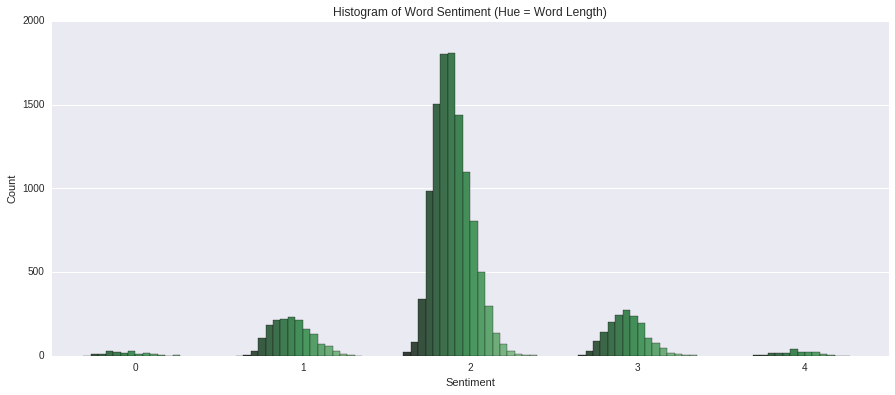

In [12]:
# Plots a histogram of the word sentiment, by word length
plt.figure(figsize=(15, 6))
ax = sns.countplot(x="Sentiment", data=single_words, hue=single_words.Phrase.str.len(), palette="Greens_d")
ax.legend().set_visible(False)
plt.title("Histogram of Word Sentiment (Hue = Word Length)")
plt.ylabel("Count")

It is often the case that one key positive or negative term completely changes the sentiment of the sentence. As a simple model, we used this observation to calculate the sentiment of each phrase by using the sentiment of the most extreme word in each phrase.

In [13]:
''' Splits the phrase into a list of words '''
def get_words(phrase):
    words = phrase.split()
    new_words = []
    for w in words:
        new_words.append(w.lower().strip('.,;!?"()'))
    
    return new_words

''' Gets the most extreme sentiment value in the sentence and returns it '''
def get_extreme_sentiment(phrase):
    words = get_words(phrase)
    most_sentiment = 2
    
    for w in words:
        if w in corpus:
            sentiment = corpus[w]
            if abs(sentiment - 2) >= abs(most_sentiment - 2):
                most_sentiment = sentiment
        if w in not_corpus:
            sentiment = not_corpus[w]
            if abs(sentiment - 2) >= abs(most_sentiment - 2):
                most_sentiment = sentiment
        
    return most_sentiment

# Predicts the first 5 sentiment values
predictions = test.Phrase.apply(get_extreme_sentiment)

# Generates the csv file
submission = pd.DataFrame({
        "PhraseId": test["PhraseId"],
        "Sentiment": predictions
    })

submission.to_csv("benchmark_iteration.csv", index=False)

This model ended up being 54.682% accurate on Kaggle, which isn't terrible. However, we can improve the model slightly by using a Naive Bayes approach instead.

## Naive Bayes Model

The Naive Bayes model estimates the probability that a document belongs to a certain sentiment class. The simplified formula for the model is shown below:

$c = \max_\limits{c\:\in\:C}\:\Big( P(c)\: \cdot \prod_\limits{x\:\in\:X} P(x\:|\:c)\Big)$

We need to calculate $P(c)$, the probability of a sentiment class appearing in the data, and for each word, P(x\:|\:c), the probability that a word $x$ appears in sentiment class $c$. We started with $P(c)$, since it was easier. The histogram below shows the distribution of all the classes in the data:

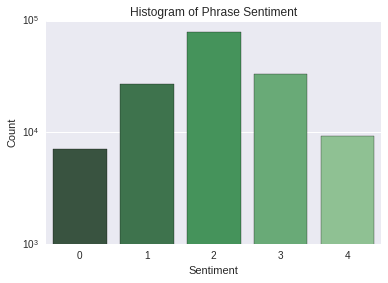

In [14]:
# Plots the sentiment histogram on a semilog-y plot
sns.countplot(x="Sentiment", data=train, palette="Greens_d")
plt.title("Histogram of Phrase Sentiment")
plt.ylabel("Count")
plt.yscale('log')

It's pretty obvious from this that we're most likely to encounter a phrase that is neutral. So, $P(c)$ for sentiment 2 should be the highest.

In [15]:
# Calculates the probability of any given phrase having a particular sentiment
P_c = []
for i in range(5):
    prob = len(train[train.Sentiment == i]) / float(len(train))
    P_c.append(prob)
    
print "Pr{Sentiment 0}: " + str(P_c[0])[:6]
print "Pr{Sentiment 1}: " + str(P_c[1])[:6]
print "Pr{Sentiment 2}: " + str(P_c[2])[:6]
print "Pr{Sentiment 3}: " + str(P_c[3])[:6]
print "Pr{Sentiment 4}: " + str(P_c[4])[:6]

Pr{Sentiment 0}: 0.0453
Pr{Sentiment 1}: 0.1747
Pr{Sentiment 2}: 0.5099
Pr{Sentiment 3}: 0.2109
Pr{Sentiment 4}: 0.0589


Next, we need to figure out how probable it is for a word to appear in a certain sentiment class. We started by counting how many times each word appears in all the phrases of a sentiment class. It is very likely, for instance, for the word "exciting" to appear in very positive phrase.

In [16]:
# Extracts just the sentences from the dataset and combines them into mega-strings
sentences_dict = train['SentenceId'].drop_duplicates()
sentences = train.iloc[sentences_dict.keys()]
sentences.head()

# For each sentiment's mega-string, counts the number of times each word appears
text = []
for i in range(5):
    d = {}
    temp = sentences[sentences.Sentiment == i]
    words_in_class = ' '.join(temp.Phrase.values).lower().split()
    for w in words_in_class:
        new_word = w.lower().strip('.,;!?"()')
        if not new_word.strip(string.ascii_letters) and new_word != '':
            d[new_word] = d.get(new_word,0) + 1

    text.append(d)

print "How many times does the word \"exciting\" appear in sentiment 4 phrases?"
print text[4]['exciting']
print "How many times does the word \"exciting\" appear in sentiment 0 phrases?"
print text[0]['exciting']

How many times does the word "exciting" appear in sentiment 4 phrases?
8
How many times does the word "exciting" appear in sentiment 0 phrases?
2


Next, the probability of the word appearing in a sentiment class $P(w\: | \: c)$ needs to be calculated. This can be done by simply dividing each of the counts by the total number of words in the dictionary. However, we need to multiply the probabilities together, so if a word appears 0 times, the entire product will go to zero. In order to avoid this, we added Laplace (or plus-one) smoothing, so that the probability will never be zero.

The expression $\frac{0}{N}$ becomes $\frac{1}{N + len(V)}$ when the smoothing is applied.

In [17]:
# Calculates the probability of a word being in a particular class for every word in the corpus
P_wc = []
alpha = 1.0 # Laplace smoothing
for d in text:
    n_words_in_class = sum(d.values())
    new_dict = {}
    for w in corpus:
        if w in d:
            new_dict[w] = (d[w] + alpha) / (n_words_in_class + alpha*len(corpus))
        else:
            new_dict[w] = alpha / len(corpus)
    for w in not_corpus:
        if w in d:
            new_dict[w] = (d[w] + alpha) / (n_words_in_class + alpha*len(corpus))
        else:
            new_dict[w] = alpha / len(corpus)
    P_wc.append(new_dict)
    
print "Probability of the word \"yellow\" appearing in a sentiment 2 phrase: "
print P_wc[2]['yellow']

Probability of the word "yellow" appearing in a sentiment 2 phrase: 
5.01957634776e-05


Now all that needs to be done is to multiply all of the probabilities in the way shown in the equation earlier. This is done for each sentiment class, and the sentiment with the highest probability will become the sentiment of the phrase.

We made a couple improvements to the base Naive Bayes model. First, we ignored all words that were labeled "miscellaneous" by the part-of-speech tagger. We also used Pattern's sentiment analysis tool to help calculate the sentiment of phrases that our model perceived to be neutral.

In [18]:
''' Splits the phrase into a list of words '''
def get_words(phrase):
    words = phrase.split()
    new_words = []
    for w in words:
        new_words.append(w.lower().strip('.,;!?"()'))
    
    return new_words

''' Calculates the sentiment of a phrase using a Naive bayes classifier '''
def naive_bayes(phrase):
    if phrase in corpus:
        return corpus[phrase]
    if phrase in not_corpus:
        return not_corpus[phrase]
    
    P_cw = 0 # Probability that the phrase has a sentiment c
    words = get_words(phrase)
    
    for s in range(5):
        # Probability of the sentiment occurring
        prob = P_c[s]
        
        # Probability of the word appearing in the sentiment class
        for w in words:
            # Ignores words with miscellaneous parts of speech
            if w in corpus and part_of_speech[w] != "misc":
                prob *= P_wc[s][w]
            if w in not_corpus and part_of_speech[w[4:]] != "misc":
                prob *= P_wc[s][w]
            
        if prob > P_cw:
            P_cw = prob
            sentiment = s
            
    # Double checks the sentiment using Pattern's sentiment analysis package
    if sentiment == 2:
        pattern_sent = pattern.en.sentiment(phrase)
        if abs(pattern_sent[0]) > 0.1:
            sentiment += int(round(pattern_sent[0] * 2))
        
    return sentiment

Our accuracy on the training data improved! (It was .547 before)

In [19]:
train["Predictions"] = train.Phrase.apply(naive_bayes)
print "Train accuracy: " + str(len(train[train.Sentiment == train.Predictions]) / float(len(train)))

Train accuracy: 0.559284890427


The score we got on Kaggle for this submission was 56.987%.

In [20]:
# Generates the csv file
predictions = test.Phrase.apply(naive_bayes)
submission = pd.DataFrame({
        "PhraseId": test["PhraseId"],
        "Sentiment": predictions
    })

submission.to_csv("final_iteration.csv", index=False)

## Future Work

There are a few glaring drawbacks to the Naive Bayes approach, mainly due to the fact that the bag-of-words model assumes that the ordering of the words does not matter. Sentences that have more complex structures can be weighted differently based on what words come first. Additionally, the model does not do a very good job when it sees a bunch of adjectives in a row, such as "intrigue, betrayal, decit, and murder" or "quite, introspective, and entertaining." In both examples, the authors probably wanted to create emphasis, and the model should be able to detect that.

In [21]:
train[train.Sentiment != train.Predictions]

,PhraseId,SentenceId,Phrase,Sentiment,POS,Negations,Predictions
0,1,1,A series of escapades demonstrating the adage ...,1,"[DT, NN, IN, NNS, VBG, DT, NN, IN, WP, VBZ, JJ...",A series of escapades demonstrating the adage ...,3
1,2,1,A series of escapades demonstrating the adage ...,2,"[DT, NN, IN, NNS, VBG, DT, NN, IN, WP, VBZ, JJ...",A series of escapades demonstrating the adage ...,3
5,6,1,of escapades demonstrating the adage that what...,2,"[IN, NNS, VBG, DT, NN, IN, WP, VBZ, JJ, IN, DT...",of escapades demonstrating the adage that what...,3
7,8,1,escapades demonstrating the adage that what is...,2,"[NNS, VBG, DT, NN, IN, WP, VBZ, JJ, IN, DT, NN]",escapades demonstrating the adage that what is...,3
9,10,1,demonstrating the adage that what is good for ...,2,"[VBG, DT, NN, IN, WP, VBZ, JJ, IN, DT, NN]",demonstrating the adage that what is good for ...,3
15,16,1,that what is good for the goose,2,"[DT, WP, VBZ, JJ, IN, DT, NN]",that what is good for the goose,3
17,18,1,what is good for the goose,2,"[WP, VBZ, JJ, IN, DT, NN]",what is good for the goose,3
19,20,1,is good for the goose,2,"[VBZ, JJ, IN, DT, NN]",is good for the goose,3
27,28,1,"is also good for the gander , some of which oc...",2,"[VBZ, RB, JJ, IN, DT, NN, ,, DT, IN, WDT, RB, ...","is also good for the gander , some of which oc...",3
28,29,1,"is also good for the gander , some of which oc...",2,"[VBZ, RB, JJ, IN, DT, NN, ,, DT, IN, WDT, RB, ...","is also good for the gander , some of which oc...",3
